In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.utils.np_utils import to_categorical
from keras.layers import Dense
from keras.models import Sequential
from keras import optimizers
from keras import backend
from keras.callbacks import EarlyStopping

#### Labels & others

In [11]:
# labels
dict_things = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

import os
os.environ["TF_MIN_GPU_MULTIPROCESSOR_COUNT"]="2"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

# input layer size
layer_size_0 = 28*28  # 784

# check GPU
print(tf.config.experimental.list_physical_devices('GPU'))

from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import gc

# Reset Keras Session | clear memory GPU
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    gc.collect() # if it does something you should see a number as output

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Split dataset

In [12]:
(X_train, y_train_labels), (X_test, y_test_labels) = fashion_mnist.load_data()

print(X_train.shape, X_test.shape)
print(y_train_labels.shape)

(60000, 28, 28) (10000, 28, 28)
(60000,)


#### Random thing

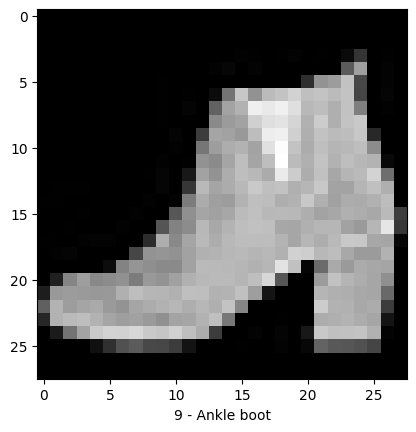

In [13]:
index = np.random.randint(0, X_train.shape[0])
index_thing = y_train_labels[index]

plt.imshow(X_train[index], cmap="gray")
plt.xlabel(f"{index_thing} - {dict_things[index_thing]}")
plt.show()

#### Normalization

In [14]:
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train.min(), X_train.max()

X_train = X_train.reshape((-1, 28 * 28))
X_test = X_test.reshape((-1, 28*28))
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

#### One hot

In [15]:
y_train = to_categorical(y_train_labels)
y_test = to_categorical(y_test_labels)

y_train[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

#### Optimizers comparison

In [16]:
# %%time
#
# models = {}
#
# plt.figure(figsize=(16, 7))
# colors = ['g', 'b', 'r', 'y']
#
# num_epochs = 4
# batch_size = 32
#
# epoch = np.arange(num_epochs+1)
#
# for i, i_optim in enumerate([optimizers.gradient_descent_v2.SGD(),
#                              optimizers.adagrad_v2.Adagrad(),
#                              optimizers.rmsprop_v2.RMSProp(),
#                              optimizers.adam_v2.Adam()
#                             ]):
#     model_i = Sequential([
#         Dense(64, input_shape=(layer_size_0,), activation='relu'),
#         Dense(32, activation='relu'),
#         Dense(10, activation='sigmoid')
#     ])
#
#     model_i.load_weights('./samples/experimental_weights.h5')
#
#     model_i.compile(
#         optimizer=i_optim,
#         loss='categorical_crossentropy',
#         metrics='accuracy'
#     )
#
#     h0_train = model_i.evaluate(X_train, y_train, verbose=0)
#     h0_val = model_i.evaluate(X_test, y_test, verbose=0)
#
#     h = model_i.fit(X_train, y_train,
#                     epochs=num_epochs,
#                     batch_size=batch_size,
#                     validation_data=(X_test, y_test),
#                     verbose=0)
#
#     models[i_optim.get_config()['name']] = model_i
#
#     plt.plot(epoch, np.log([h0_train[0]] + h.history['loss']), '-', c=colors[i],
#              label=model_i.optimizer.get_config()['name'] + ' train')
#
#     plt.plot(epoch, np.log([h0_val[0]] + h.history['val_loss']), '--', c=colors[i],
#              label=model_i.optimizer.get_config()['name'] + ' val')
#
# plt.legend()
# plt.title('NN with log(loss)')
# plt.xlabel('epochs')
# plt.ylabel('log(loss)')
# plt.show()
#
# # choice -> adam

#### Hide layer size

In [17]:
# Size hide layer => 784 | x | 10
batch_size = 100
evaluation = { 'train': [], 'test': [] }
layers_size = [i for i in range(10)] + [i**2 for i in range(4, 20) if i % 2 == 0]

for layer_size in layers_size:
    # clear memory GPU
    reset_keras()

    # skeleton
    model = Sequential([
        Dense(layer_size, input_shape=(layer_size_0,), activation='relu'),
        Dense(10, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics='accuracy'
    )

    # learning
    model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=10,
        verbose=0,
        validation_data=(X_test, y_test)
    )

    # loss, metrics
    train_evals = model.evaluate(X_train, y_train, verbose=0, batch_size=batch_size)
    test_evals = model.evaluate(X_test, y_test, verbose=0, batch_size=batch_size)

    evaluation['train'].append(train_evals)
    evaluation['test'].append(test_evals)

    if layer_size % 6 == 0:
        print(f'Size of hide layer: {layer_size}')
        print(f'Train Loss: {train_evals[0]:.3f}\tTrain Accuracy: {train_evals[1]:.3f}')
        print(f'Test Loss: {test_evals[0]:.3f}\tTest Accuracy: {test_evals[1]:.3f}\n')

Size of hide layer: 0
Train Loss: 2.303	Train Accuracy: 0.100
Test Loss: 2.303	Test Accuracy: 0.100

Size of hide layer: 6
Train Loss: 0.442	Train Accuracy: 0.847
Test Loss: 0.487	Test Accuracy: 0.833

Size of hide layer: 36
Train Loss: 0.306	Train Accuracy: 0.889
Test Loss: 0.380	Test Accuracy: 0.863

Size of hide layer: 144
Train Loss: 0.232	Train Accuracy: 0.914
Test Loss: 0.329	Test Accuracy: 0.885

Size of hide layer: 324
Train Loss: 0.233	Train Accuracy: 0.913
Test Loss: 0.345	Test Accuracy: 0.878



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 16, 36, 64, 100, 144, 196, 256, 324]


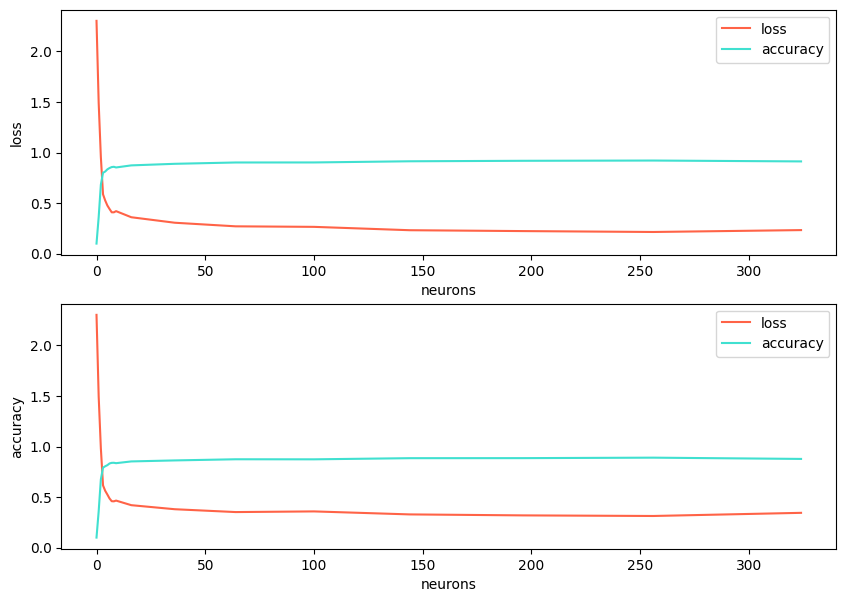

In [18]:
print(layers_size)

plt.figure(figsize=(10, 7))

plt.subplot(2, 1, 1)
plt.plot(layers_size, np.array(evaluation['train'])[:, 0], c='tomato', label="loss")
plt.plot(layers_size, np.array(evaluation['train'])[:, 1], c='turquoise', label="accuracy")
plt.xlabel("neurons")
plt.ylabel("loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(layers_size, np.array(evaluation['test'])[:, 0], c='tomato', label="loss")
plt.plot(layers_size, np.array(evaluation['test'])[:, 1], c='turquoise', label="accuracy")
plt.xlabel("neurons")
plt.ylabel("accuracy")
plt.legend()

plt.show()

#### Number of hidden layers

In [ ]:
# 600 neurons in all hidden layers
loss_accuracy = []

for i in range(0, 10):
    layers, neurons = i, round(600 / (i+1))

    # skeleton
    model = Sequential()
    model.add(Dense(neurons, input_shape=(layer_size_0,), activation='relu'))
    for _ in range(layers):
        model.add(Dense(neurons, activation='relu'))
    model.add(Dense(10, activation='sigmoid'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics='accuracy'
    )

    # learning
    history = model.fit(
        X_train, y_train,
        batch_size=60,
        epochs=10,
        verbose=0
    )



    # clear memory GPU
    backend.clear_session()

    # loss, metrics
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

    loss_accuracy.append((loss, accuracy))

    print(f'number hid den layers: {layers + 1} |\n'
          f'neurons in one layer: {neurons} |\n'
          f'Test Loss: {loss:.3f} | Test Accuracy: {accuracy:.3f}\n'
    )

In [ ]:

batches = [75]

for batch in batches:
    K.clear_session()  # clear GPU
    model = Sequential([
        Dense(64, input_shape=(28*28,), activation='relu'),
        Dense(25, activation='relu'),
        Dense(10, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train, batch_size=batch, epochs=20, verbose=1)

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

    print(f'epochs: {batch} | Test Loss: {loss:.3f} | Test Accuracy: {accuracy:.3f}')